# Extended data supporting the study of rundown experiments on L-type calcium current

This notebook provides supporting material that supplements the understanding of the methods undertaken and the results obtained in this study in Sections A and B respectively

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

import helpers
import extensions

out_dir = ['BT_10', 'BT_20', 'BT_40', 'RT_10', 'RT_20', 'RT_40']

### A. Supporting material for methods

This section shows the relationship between $g_{leak}$ and $R_{seal}$ (Section A.1), the number of cells selected by the quality control criteria (Section A.2), and verifies the linearity of $X_{eff}$ derived in the paper with respect to voltage (Section A.3).

##### A.1 $g_{leak}$ dependence on $R_{seal}$

The strength of the leak current in the patch-clamp setup used in this study is affected by how well the cell is attached to the chip-plate.
Therefore, the leak conductance is inversely dependent on the seal resistance as shown in the scatter plot below.

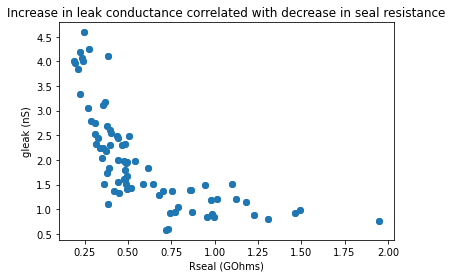

In [2]:
#### Plot that shows the inverse relationship between Rseal and gleak
rseal_arr = []
gleak_arr = []
for dir in out_dir:
    files = os.listdir(f'output/{dir}')
    for f in files:
        if f[:4] == 'prop':
            data = pd.read_csv(f'output/{dir}/{f}')
            gleak = data['gleak (nS)'].median()
            rseal = data['rseal (GOhms)'].median()
            rseal_arr.append(rseal)
            gleak_arr.append(gleak)

fig = plt.figure(facecolor='white')
plt.scatter(rseal_arr, gleak_arr)
plt.xlabel('Rseal (GOhms)')
plt.ylabel('gleak (nS)')
plt.title('Increase in leak conductance correlated with decrease in seal resistance')
plt.show()
plt.close()

##### A.2 Number of cells selected

The number of cells selected from each chip plate by applying different QC mentioned in the main papaer are given below

In [3]:
extensions.select_cell_per_qc()

temp hold | QC0 QC1.1 QC1.2 QC1.3 QC2.1 QC2.2 QC3 QC4 QC5 | SELECTED
-----------------------------------------------------------------
BT 10 | 74 63 74 74 65 46 48 73 70 | 36
BT 20 | 50 44 50 48 43 37 34 47 45 | 24
BT 40 | 52 37 50 48 43 26 31 50 49 | 18
RT 10 | 44 43 44 44 39 31 19 44 42 | 18
RT 20 | 56 55 56 55 55 43 40 55 56 | 35
RT 40 | 40 37 40 36 40 31 32 38 40 | 25


##### A.3 $X_{eff}$ verification

The derivation for $X_{eff}$ in the study suggests that leak due to individual ions varies non-linearly with respect to volatge.
However, the leak current itself has been derived by assuming a linear dependence on voltage (Equation 1 in the paper).
This contradiction is resolved by plotting the total $X_{eff}$ against voltage and observing that while leak due to individual ions such as Na, Ca, K, varies non-linearly with voltage, the sum of $X_{eff}$ due to all ions in the solution varies linearly with voltage.
$X_{eff}$ can therefore be used to estimate the leak current due to calcium.

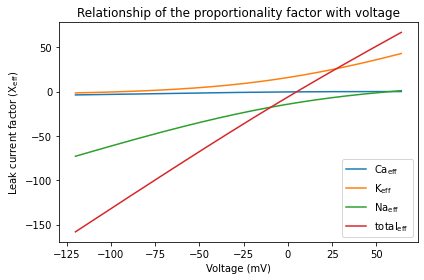

In [4]:
#### Plot showing that derived leak is linear

volt_arr = [i for i in range(-120, 65, 1)]
volt_arr = [volt + 0.01 for volt in volt_arr]
volt_arr = pd.DataFrame(volt_arr, columns = ['Voltage'])

X_K, X_Na, X_Ca, _, _, _, _, X_tot = \
    helpers.leak_proportion_calcium('BT', volt_arr['Voltage'])

fig = plt.figure(facecolor='white')
plt.plot(volt_arr, X_Ca, label = '$\mathregular{Ca_{eff}}$')
plt.plot(volt_arr, X_K, label = '$\mathregular{K_{eff}}$')
plt.plot(volt_arr, X_Na, label = '$\mathregular{Na_{eff}}$')
plt.plot(volt_arr, X_tot, label = '$\mathregular{total_{eff}}$')

plt.legend()
plt.xlabel('Voltage (mV)')
plt.ylabel('Leak current factor ($\mathregular{X_{eff}}$)')
plt.title('Relationship of the proportionality factor with voltage')
plt.tight_layout()
plt.show()
plt.close()

In [5]:
_, _, X_Ca, _, _, _, _, total = \
    helpers.leak_proportion_calcium('BT', pd.DataFrame([-90])[0])
X_hold = X_Ca/total
_, _, X_Ca, _, _, _, _, total = \
    helpers.leak_proportion_calcium('BT', pd.DataFrame([-0.0001])[0])
X_step = X_Ca/total

print(f'At the holding potential of -90 mV, {round(X_hold[0]*100, 2)}% of the leak current is due to movement of calcium ions')
print(f'At the step voltage of of 0 mV, {round(X_step[0]*100, 2)}% of the leak current is due to movement of calcium ions')

At the holding potential of -90 mV, 2.41% of the leak current is due to movement of calcium ions
At the step voltage of of 0 mV, 7.01% of the leak current is due to movement of calcium ions


### B. Supporting material for results

This section covers some basic checks to understand the level of rundown, its shape, and the rundown rate (Section B.1), determine the fraction of calcium moles brought in by leak current (Section B.2), and finally perform some checks on the multi-linear regression analysis presented in the paper (Section B.3).

##### B.1 Basic checks to understand results

Examine the results to determine the level of rundown obtained, split the cells according to the shape of their rundown-versus-time curve, and the rate of rundown.

In [6]:
## rundown data basic check
final_run = []
for dir in out_dir:
    fname = f'output/{dir}/'
    files = os.listdir(fname)
    for f in files:
        if f[4:] == 'csv':
            data = pd.read_csv(fname + f'{f}').min(axis=0)
            final_run.append(data.iloc[-1]/data.iloc[0])

print(f"On an average, current is reduced to {np.median(final_run)*100}% of its initial value")
print(f"The minimum reduction was to {np.max(final_run)*100}%, while the maximum reduction was to {np.min(final_run)*100}% of its initial value")
            

On an average, current is reduced to 44.75908617506903% of its initial value
The minimum reduction was to 121.79852991972486%, while the maximum reduction was to 13.668249821217938% of its initial value


In [7]:
# Load relevant data
data = pd.read_csv('output/r_rate_database.csv')
r_rate = data['Run rate']

print(f"On an average, current is reduced at the rate of {np.median(r_rate)} per min")

On an average, current is reduced at the rate of 0.07678519659722655 per min


In [8]:
## Rundown versus time curve
shape = data['shape']
linear = len(shape[shape == 'Linear'])
saturating = len(shape[shape == 'Saturating'])
other = len(shape[shape == 'Other'])
total = linear + saturating + other

print('Percentage of cells exhibiting a linear function: ', 100*linear/total)
print('Percentage of cells exhibiting a saturating function: ', 100*saturating/total)
print('Percentage of cells exibiting other functions: ', 100*other/total)



Percentage of cells exhibiting a linear function:  35.256410256410255
Percentage of cells exhibiting a saturating function:  21.794871794871796
Percentage of cells exibiting other functions:  42.94871794871795


##### B.2 Fraction of calcium moles brought in by leak current

There are two sources of calcium into the cell: the L-type calcium current and the leak current. Here we examine the fraction of calcium moles brought into the cell due to leak current.

On an average, 32% of the calcium moles are brought in by the leak current (marked by a red line)


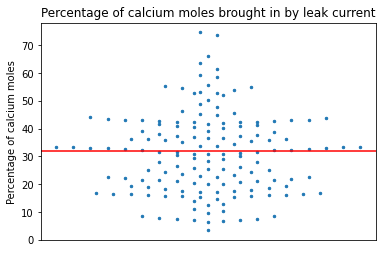

In [9]:
# Ca moles from leak and ICaL

# load the fraction
dat = pd.read_csv('resources/ca_leak_frac.csv')['leak moles frac']
average = round(100 * dat.median())
print(f'On an average, {average }% of the calcium moles are brought in by the leak current (marked by a red line)')

dat = dat.values.tolist()
dat = [x*100 for x in dat]

x_arr = extensions.simple_beeswarm(dat)

fig = plt.figure(facecolor='white')

plt.scatter(x_arr, dat, s=6)

plt.title('Percentage of calcium moles brought in by leak current')
plt.ylabel('Percentage of calcium moles')
plt.axhline(y=average, color = 'red')
plt.xticks([])
plt.show()
plt.close()

##### B.3 Rundown per pulse

For each experimental condition, we find that the rundown per pulse (or sweep) is more for the experiemntal condition at which the there are lesser number of pulses, suggesting that a significant amount of rundown occurs due to time-dependent processes.

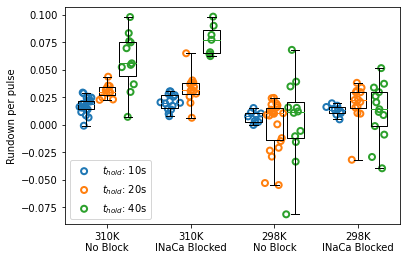

In [2]:
fig = helpers.rundown_per_pulse()
plt.show()
plt.close()

##### B.3 Regression checks

Here we show the coefficient values obtained from the multi-linear regression along with their confidence intervals.
We then calculated the rundown rate predicetd by the model and used to estimate the residuals.
These were then used to check four assumptions of performing a multi-linear regression.

1. Linearity: Ideally the scatter plot of predicted versus actual values should lie exactly on a diagnol. While this is not completely true for the plot shown in this section, the variation is horizontally on both sides of the diagnol which is expected given that temperature and INaCa are used as discrete rather than continuous variables.
2. Normality: The residuals form part of a normal-like distribution with a slight skew on the right side, however, given the complexity of the data, this is not too concerning.
3. Non-autocorrelation: The Durbin-Watson test was performed on the residuals which passed and confirmed that the errors are not auto-correlated
4. Homoscedasticity: The residuals do not have a constant variance throughout which can again be attributed to the fact that some of the variables of the model are discrete rather than continuous.

While all the assmptions of the linear regression are not satisfied, this can be attributed to several factors including: 1) there are several over fctors that affect the calcium concentration inside a cell, 2) there are factors besides intracellular calcium that affect rundown, and 3) the nature of some of the variables in this study only allows them to be observed at discrete rather than continuous values.

Since the purpose of the regression model is not to determine a value given the observations of temperature, $t_{hold}$, and INaCa; but rather to confirm the direction of the relationship of each of these factors towards rundown and to determine their statistical significance, this regression is fit for purpose.


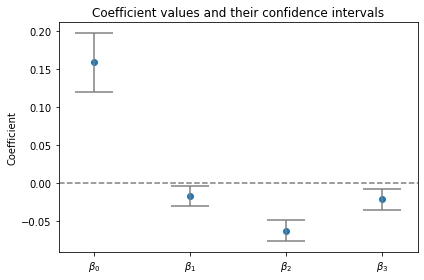

beta_1: Two-sided p-value -> 0.01342 and one-sided p-value -> 0.00671
beta_2: Two-sided p-value -> 4.16e-15 and one-sided p-value -> 2.08e-15
beta_3: Two-sided p-value -> 0.00321 and one-sided p-value -> 0.00161


In [10]:
# defaults: INaCa_off = 0, INaCa_on = 1; temp_310 = 0, temp_298 = 1
# equation: r_rate = b_0 + b_1 * (log(thold)) + b_2 * (temp_298) + b_3 * (INaCA_On)
b_0, b_1, b_2, b_3 = 0.158795, -0.016373, -0.062213, -0.021030
ci_l_0, ci_u_0 =  0.11984411,  0.197745292
ci_l_1, ci_u_1 = -0.02930387, -0.003442791
ci_l_2, ci_u_2 = -0.07628548, -0.048139628
ci_l_3, ci_u_3 = -0.03490557, -0.007153578

# Plot Confidence interval and beta values
fig = plt.figure(facecolor='white')

plt.scatter(0, b_0, color = 'tab:blue')
plt.hlines(ci_l_0, xmin = -0.2, xmax = 0.2, color = 'grey')
plt.hlines(ci_u_0, xmin = -0.2, xmax = 0.2, color = 'grey')
plt.vlines(0, ymin = ci_l_0, ymax = ci_u_0, color = 'grey')

plt.scatter(1, b_1, color = 'tab:blue')
plt.hlines(ci_l_1, xmin = 0.8, xmax = 1.2, color = 'grey')
plt.hlines(ci_u_1, xmin = 0.8, xmax = 1.2, color = 'grey')
plt.vlines(1, ymin = ci_l_1, ymax = ci_u_1, color = 'grey')

plt.scatter(2, b_2, color = 'tab:blue')
plt.hlines(ci_l_2, xmin = 1.8, xmax = 2.2, color = 'grey')
plt.hlines(ci_u_2, xmin = 1.8, xmax = 2.2, color = 'grey')
plt.vlines(2, ymin = ci_l_2, ymax = ci_u_2, color = 'grey')

plt.scatter(3, b_3, color = 'tab:blue')
plt.hlines(ci_l_3, xmin = 2.8, xmax = 3.2, color = 'grey')
plt.hlines(ci_u_3, xmin = 2.8, xmax = 3.2, color = 'grey')
plt.vlines(3, ymin = ci_l_3, ymax = ci_u_3, color = 'grey')

plt.axhline(0, color = 'grey', ls = '--')

plt.xticks([0, 1, 2, 3], [r'$\beta_0$', r'$\beta_1$', r'$\beta_2$', r'$\beta_3$'])
plt.ylabel('Coefficient')
plt.title('Coefficient values and their confidence intervals')

plt.tight_layout()
plt.show()
plt.close()

print('beta_1: Two-sided p-value -> 0.01342 and one-sided p-value -> 0.00671')
print('beta_2: Two-sided p-value -> 4.16e-15 and one-sided p-value -> 2.08e-15')
print('beta_3: Two-sided p-value -> 0.00321 and one-sided p-value -> 0.00161')

In [11]:
res_arr = []
r_rate_pred_arr = []

for i in range(len(data)):
    thold = np.log(data.iloc[i]['thold'])

    if data.iloc[i]['Temperature'] == 310:
        temp = 0
    elif data.iloc[i]['Temperature'] == 298:
        temp = 1
    else:
        raise ValueError ('Temperature is not defined')

    if data.iloc[i]['INaCa'] == 'Off':
        inaca = 0
    elif data.iloc[i]['INaCa'] == 'On':
        inaca = 1
    else:
        raise ValueError ('INaCa is not defined')

    r_rate_pred = b_0 + b_1 * thold + b_2 * temp + b_3 * inaca
    r_rate_actual = data.iloc[i]['Run rate']
    res_cell = r_rate_pred - r_rate_actual
    res_arr.append(res_cell)
    r_rate_pred_arr.append(r_rate_pred)

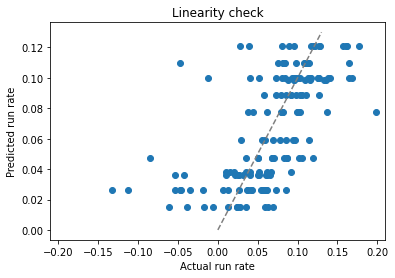

In [12]:
# Assumption 1: Linearity
fig = plt.figure(facecolor='white')
arr = np.arange(0, 0.131, 0.002)
plt.scatter(data['Run rate'], r_rate_pred_arr, color = 'tab:blue')
plt.plot(arr, arr, color = 'grey', ls = '--')
plt.xlabel('Actual run rate')
plt.ylabel('Predicted run rate')
plt.xlim(-0.21, 0.21)
plt.title('Linearity check')
plt.show()
plt.close()

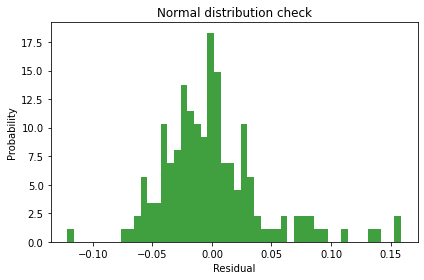

In [13]:
# Assumption 2: Normality
res_pd = pd.DataFrame(pd.DataFrame(res_arr))
fig = plt.figure(facecolor='white')
ax2 = fig.add_subplot(111)

ax2.hist(res_pd, 50, density=True, facecolor='g', alpha=0.75)
ax2.set_xlabel('Residual')
ax2.set_ylabel('Probability')
ax2.set_title('Normal distribution check')

plt.tight_layout()
plt.show()
plt.close()

In [14]:
# Assumption 3: Auto-correlation of errors

from statsmodels.stats.stattools import durbin_watson

val = durbin_watson(res_arr)
# Autocorelation
print(f'The output of Durbin-Watson test is: {val}')

if  1.5 < val < 2.5:
    print("No autocorrelation of error and the test has passed") 
else:
    print("Error autocorrelated and the test has failed")


The output of Durbin-Watson test is: 1.968424036140333
No autocorrelation of error and the test has passed


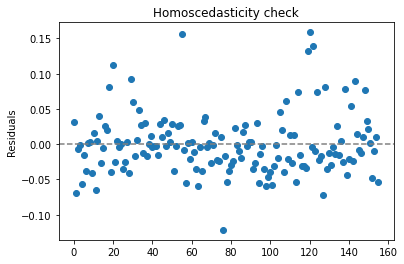

In [15]:
# Assumption 4: Homoscedasticity - residuals should have constant variance

fig = plt.figure(facecolor='white')

arr = np.arange(0, len(res_arr), 1)

plt.scatter(arr, res_arr, color = 'tab:blue')

plt.axhline(0, color = 'grey', ls = '--')
plt.ylabel('Residuals')

plt.title('Homoscedasticity check')
plt.show()
plt.close()